In [1]:
import os
import shutil

# Move kaggle.json to the correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions (just to be safe)
os.chmod('/root/.kaggle/kaggle.json', 0o600)
#!/bin/bash
!kaggle datasets download jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0


In [2]:
import zipfile

with zipfile.ZipFile('/content/weather-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('weather-dataset')

print('Dataset extracted successfully!')

Dataset extracted successfully!


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import ttest_ind, norm

In [4]:
# Define dataset path
dataset_path = "/content/weather-dataset/dataset"  # Change this to your dataset path

# Image preprocessing (Convert to Grayscale)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [5]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    subset='validation'
)


Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


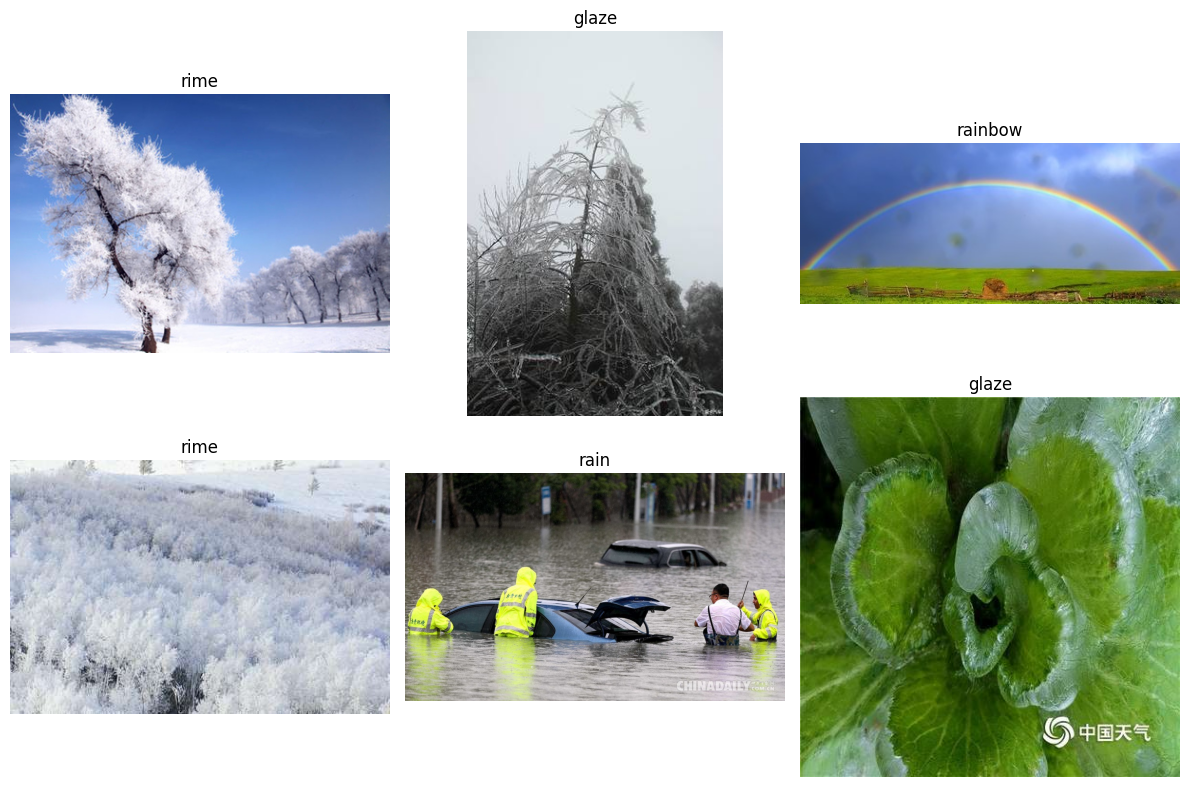

In [13]:
import matplotlib.pyplot as plt
import os
import random
import cv2

# Get class names (folder names)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# Plot sample images from random classes
plt.figure(figsize=(12, 8))

for i in range(6):  # Show 6 random images
    class_name = random.choice(classes)
    class_path = os.path.join(dataset_path, class_name)

    # Get random image from the selected class
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)

    # Read and convert image to RGB (if needed)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Define CNN model for grayscale images
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),  # 1 channel for grayscale
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step - accuracy: 0.2301 - loss: 2.2170 - val_accuracy: 0.4858 - val_loss: 1.6011
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.4192 - loss: 1.6473 - val_accuracy: 0.5091 - val_loss: 1.4193
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5108 - loss: 1.4054 - val_accuracy: 0.5376 - val_loss: 1.3081
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.5625 - loss: 1.2350 - val_accuracy: 0.5829 - val_loss: 1.2050
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.6237 - loss: 1.0504 - val_accuracy: 0.5895 - val_loss: 1.1849
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.6647 - loss: 0.9129 - val_accuracy: 0.6099 - val_loss: 1.1803
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.7229 - loss: 0.7742 - val_accuracy: 0.6209 - val_loss: 1.1753
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.7509 - loss: 0

In [8]:
# Get true labels and predictions
y_true = []
y_pred = []
y_prob = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class index
    preds = model.predict(X_batch)
    y_pred.extend(np.argmax(preds, axis=1))
    y_prob.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

Classification Report:
              precision    recall  f1-score   support

         dew       0.73      0.63      0.67       139
     fogsmog       0.68      0.59      0.63       170
       frost       0.52      0.24      0.33        95
       glaze       0.50      0.61      0.55       127
        hail       0.65      0.64      0.64       118
   lightning       0.80      0.75      0.77        75
        rain       0.56      0.55      0.56       105
     rainbow       0.60      0.46      0.52        46
        rime       0.66      0.84      0.74       232
   sandstorm       0.49      0.63      0.55       138
        snow       0.53      0.46      0.49       124

    accuracy                           0.61      1369
   macro avg       0.61      0.58      0.59      1369
weighted avg       0.61      0.61      0.60      1369



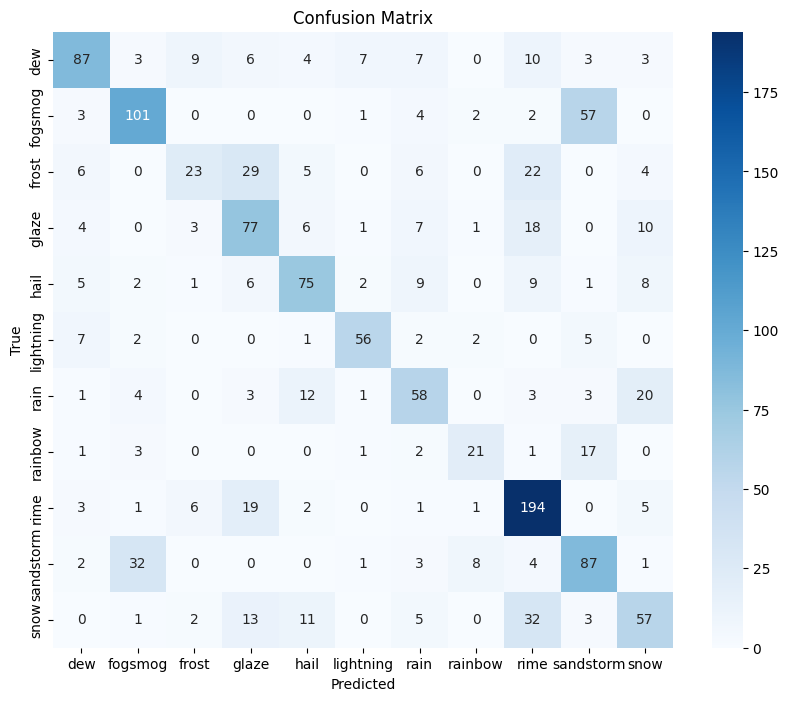

In [9]:
# CLASSIFICATION REPORT
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# CONFUSION MATRIX
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

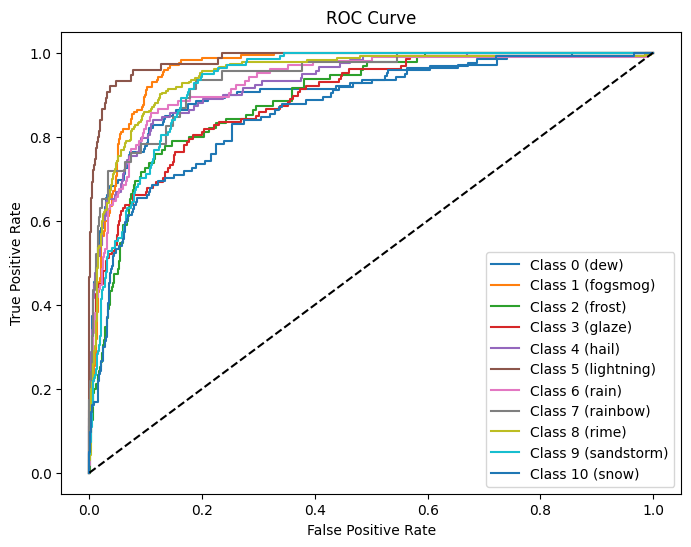

In [10]:
# ROC CURVE
plt.figure(figsize=(8, 6))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} ({list(train_generator.class_indices.keys())[i]})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [11]:
from scipy.stats import ttest_ind, norm

# Z-Test
mean_pred = np.mean(y_pred)
std_pred = np.std(y_pred)
z_score = (mean_pred - np.mean(y_true)) / (std_pred / np.sqrt(len(y_pred)))
p_value_z = 2 * (1 - norm.cdf(abs(z_score)))

alpha = 0.05  # Significance level

print(f"Z-Test: Z-Score = {z_score:.4f}, P-Value = {p_value_z:.4f}")
if p_value_z < alpha:
    print("Reject the null hypothesis (H₀): Model predictions are significantly different from true labels.")
else:
    print("Accept the null hypothesis (H₀): No significant difference between model predictions and true labels.")

# T-Test
t_stat, p_value_t = ttest_ind(y_pred, y_true, equal_var=False)

print(f"T-Test: T-Statistic = {t_stat:.4f}, P-Value = {p_value_t:.4f}")
if p_value_t < alpha:
    print("Reject the null hypothesis (H₀): Model predictions are significantly different from true labels.")
else:
    print("Accept the null hypothesis (H₀): No significant difference between model predictions and true labels.")


Z-Test: Z-Score = 4.3345, P-Value = 0.0000
Reject the null hypothesis (H₀): Model predictions are significantly different from true labels.
T-Test: T-Statistic = 3.0284, P-Value = 0.0025
Reject the null hypothesis (H₀): Model predictions are significantly different from true labels.
